# Analiza pogrešaka RMF modela konačne jezgre

Napravljena je adaptacija RMF procedure za sferične jezgre (Ghambir+90) za primjenu u računu Fisherove metrike koristeći algoritamsku diferencijaciju paketa autograd. 
Konstruirana je Fisherova metrika za set parno-parnih jezgara $^8$Be, $^{12}$C, $^{16}$O, $^{20}$Ne, $^{24}$Mg, $^{28}$Si, $^{32}$S, $^{36}$Ar i $^{40}$Ca te je proveden račun pogrešaka koristeći njihove energije vezanja i nabojne radijuse izračunate funkcionalom DD-PC1. Izabrano je da pogreške svakog mjerenja iznose $10\%$ dobivene energije vezanja i nabojnog radijusa.

## Opis procedure
Osnovni kod se bazira na iterativnoj proceduri za određivanje RMF energije vezanja u sfernom sustavu koristeći bazu harmoničkog oscilatora

$R_{n,l}=N_{n,l}L(\xi^2,n,l+0.5)\xi^le^{-\xi^2/2},$

gdje je $\xi$ radijus reskaliran s parametrom $b_0=\sqrt{1.011 A^{1/3}}$, a $L(\xi^2,n,l+0.5)$ pridružen Laguerrov polinom.

Kod rješava Diracovu jednadžbu $H\psi = (\epsilon+m)\psi$ koristeći pojednostavljenu sfernu bazu uz ansatz $\psi=(f(r),ig(r))$, posebno za svaki $(j,\pi)$ blok

$\begin{pmatrix}V+M-m & \hbar c\left(\partial_r-\frac{\kappa-1}{r}\right)\\
-\hbar c\left(\partial_r+\frac{\kappa+1}{r}\right) & V-M-m\end{pmatrix}\begin{pmatrix}f\\ g\end{pmatrix} = \epsilon \begin{pmatrix}f\\ g\end{pmatrix}$

Koristeći bazu harmoničkog oscilatora, problem se svodi na blok matricu ako se koristi razvoj 
$\begin{pmatrix}f\\ g\end{pmatrix}=\begin{pmatrix}\sum\limits_{n}^{n_{max}} f_n R_{n,l}\\ \sum\limits_{\tilde n}^{\tilde n_{max}} g_{\tilde n} R_{\tilde n,\tilde l}\end{pmatrix},$

gdje su $n_{max}=(N_F-l)/2$, $\tilde n_{max}= N_F+1$,  $l(j,\pi)=l+\pi/2$, $\tilde l(j,\pi)=l-\pi/2$ i $\kappa = \pi (j+1/2)$ . U ovoj bazi problem postaje blok-dijagonalna matrica

$\begin{pmatrix} A & B^T\\
                B & -C \end{pmatrix} \begin{pmatrix}f_1\\\vdots\\ g_{\tilde n_{max}}\end{pmatrix}=\epsilon \begin{pmatrix}f_1\\\vdots\\ g_{\tilde n_{max}}\end{pmatrix},$
                
uz

$\begin{align}A_{n,n'} &= \int\limits_0^\infty r^2 dr R_{n,l} R_{n',l}(V+M-m) \\
B_{\tilde n,n'} &= \hbar c\int\limits_0^\infty r^2 dr R_{\tilde n,\tilde l} \left(-\partial_r-\frac{\kappa+1}{r}\right) R_{n',l} \\
C_{\tilde n,\tilde n'} &= \int\limits_0^\infty r^2 dr R_{\tilde n,\tilde l} R_{\tilde n',\tilde l}(M+m-V) \\
\end{align}.$

Iz dobivenih svojstvenih vektora, kod računa valne funkcije, s obzirom na sparivanje koristeći sva stanja, svako stanje ulazi u gustoće pomnoženo s faktorima $\nu^2_i$, gdje su faktori $v_i^2$ (s obzirom na degeneraciju)  određeni kemijskim potencijalom $\lambda$ i procjepom $\Delta$:

$v_i^2=(2j_i+1) \frac{1}{2}\left(1-\frac{\epsilon-\lambda}{\sqrt{(\epsilon-\lambda)^2+\Delta^2}}\right).$

Kod pronalazi optimalni kemijski potencijal tako da je zadovoljena jednadžba
$\sum\limits_i v_i^2(\lambda) = N\,ili\, Z.$

Kod tada računa gustoće $\rho_s$, $\rho_v$, $\rho_{tv}$, $\rho_c$, $\Delta\rho_s$, računa DD-PC1 potencijal, uključivo s kulonskim doprinosom, koje koristi u sljedećoj iteraciji te na kraju računa energiju vezanja i nabojni radijus.

## Detalji implementacije

Kako bi se kod mogao povezati s autograd paketom, u autogradu je napisana implementacija Laguerrovih polinoma, strukture blok matrice, trapezna metoda integracije, te funkcije eigh za dijagonalizaciju.
Pri izračunu kulonskog potencijala bilo je potrebno izbjeći singularitet, što se postiglo malom korekcijom nazivnika

$V_c(r)=2\pi e^2\int \frac{\rho_c r'^2 dr' \sin\theta d\theta}{\sqrt{0.01+r^2+r'^2-2rr'\cos\theta}}.$

Kako bi se optimiziralo vrijeme izvođenja, kemijski potencijal je izvrijednjen na fiksnoj mreži, na kojoj se tada tražio minimum razlike $\left|\sum_i v_i^2(\lambda)-(N,Z)\right|$.

Odabran je dovoljno velik broj mjerenja kako bi Fisherova metrika mogla biti nesignularna zbog nedefiniranosti problema, odnosno numerički imala pozitivne svojstvene vrijednosti. Korištenje dviju varijabli (energije vezanja i nabojnog radijusa) je prepolovilo broj jezgara koje je nužno promatrati. Odabrane su parno-parne jezgre kako bi mogli staviti $\Delta\sim 0$, no kod funkcionira za proizvoljnu jezgru.
Zbog specifičnosti implementacije eigh funkcije, jakobijan energije vezanja je morao biti razdvojen na doprinos od promjene konstanti DD-PC1 funkcionala i doprinos od promjene gustoće, koje moraju biti sumirane pri izračunu ukupnog jakobijana po energiji vezanja.

Korišen je DD-PC1 model, reparametriziran fiksnom best-fitting vrijednošću $\theta^{\mu}=\theta^{\mu}_{bf} e^{-p_\mu}$ te su unaprijed eliminirani parametri koji su u DD-PC1 modelu egzaktno nula (jer tada nema ovisnosti o $p_\mu$.

Fisherova metrika se računa kao suma po jezgrama, $a$. 

$g_{\mu\nu}=\sum\limits_a \frac{1}{\sigma_{E_a}^2}\partial_\mu E_a \partial_\nu E_a +\sum\limits_a \frac{1}{\sigma_{R_a}^2}\partial_\mu R_a \partial_\nu R_a$
## Stabilnost svojstvenih vrijednosti promjenom broja iteracija

Kod je testiran s obzirom na broj iteracija, počevši od Woods-Saxon potencijala kao početnog uvjeta. Zbog značajnih zahtjeva na radnu memoriju paketa autograd, za izračun jakobijana je korišten mali broj oscilatorskih ljusaka $N_F=3$ te do 15 iteracija. Za veći broj ljusaka, kod je realistično vrtiti s još manjim brojem iteracija. Sami izračun energije vezanja bez poziva jakobijana nema ograničenja na broj ljusaka.

In [2]:
from procedures import *
import autograd.numpy as np
import autograd as au
import matplotlib.pyplot as plt


In [ ]:
gs =[]
NF = 3
for Niter in range(1,16):
    g=0.
    for Z in range(4,22,2):
        E,RC = procedure_rescaled_charge_R(np.zeros(DDPC1.θ_bf.shape),Z,Z,0.01,0.01,NF,10,
                                          x = np.arange(0.001,3,0.2),λ = np.arange(-30,0,0.001))
        J=au.jacobian(procedure_rescaled_charge_R)(np.zeros(DDPC1.θ_bf.shape),Z,Z,0.01,0.01,NF,Niter,jacobian=True,
                                          x = np.arange(0.001,3,0.2),λ = np.arange(-30,0,0.001))

        σE = np.abs(0.1*E)
        σR = np.abs(0.1*RC)

        J1,J2,R=process_array(J[0],Niter),process_array(J[1],Niter),process_array(J[2],Niter)
        g += (J1+J2)[:,np.newaxis]*(J1+J2)[np.newaxis,:]/σE**2+R[:,np.newaxis]*R[np.newaxis,:]/σR**2
        
    gs.append(g)

In [ ]:
gs=np.load('metrics.npz')['gs']

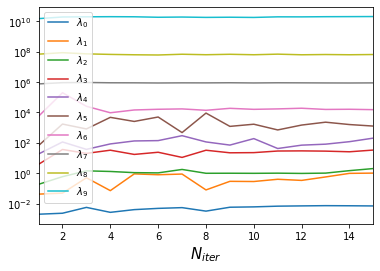

In [44]:
inds=np.array([0,1,2,3,4,5,7,9,11,12])[:,np.newaxis],np.array([0,1,2,3,4,5,7,9,11,12])[np.newaxis,:]

for j in range(gs[0][inds].shape[0]):
    plt.plot(np.arange(1,len(gs)+1),[(np.linalg.eigh(gs[k][inds])[0][j]) for k in range(len(gs))],
            label='$\lambda_{%d}$'%j)
plt.yscale('log')
plt.xlim(1,15)
plt.xlabel('$N_{iter}$',size=15)
plt.legend(loc=2)


## Stabilnost svojstvenih vektora

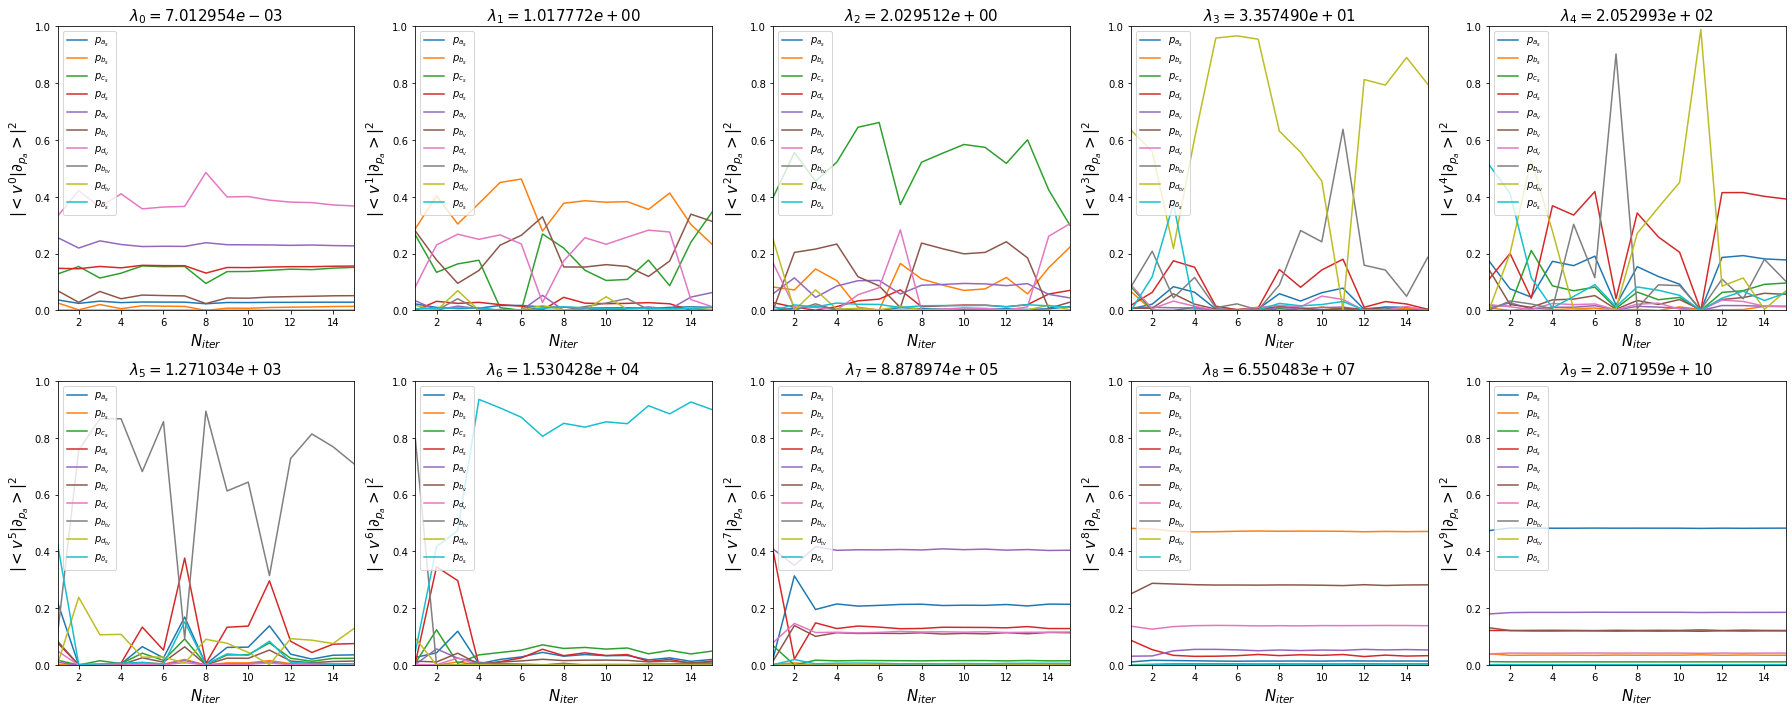

In [46]:
fig, axs = plt.subplots(2,5,figsize=(25,10))
axs = axs.reshape(-1)
for i,ax in zip(range(gs[0][inds].shape[0]),axs):
    
    for j in range(gs[0][inds].shape[0]):
        ax.plot(np.arange(1,len(gs)+1), [(np.linalg.eigh(gs[k][inds])[1][j,i])**2 for k in range(len(gs))],
                label='${p_{%s}}$'%(['a_s ','b_s ','c_s ','d_s ','a_v ','b_v ','d_v ','b_{tv}','d_{tv}','δ_s ',][j]))
    #plt.yscale('log')
    ax.set_ylim(0,1)
    ax.set_xlim(1,15)
    ax.set_ylabel('$|<v^{%d}|\partial_{p_a}>|^2$'%i,size=15)
    ax.set_xlabel('$N_{iter}$',size=15)
    ax.set_title('$\lambda_{%d}=%e$'%(i,np.linalg.eigh(gs[-1][inds])[0][i]),size=15)
    ax.legend(loc=2)
fig.tight_layout()

## Stabilnost pogrešaka parametara 
Lijeva slika prikazuje $\sigma_{p^i}$, dok desna slika pokazue $\sigma_{\theta^i}=|\theta_{bf}^i| \sigma_{p^i}$

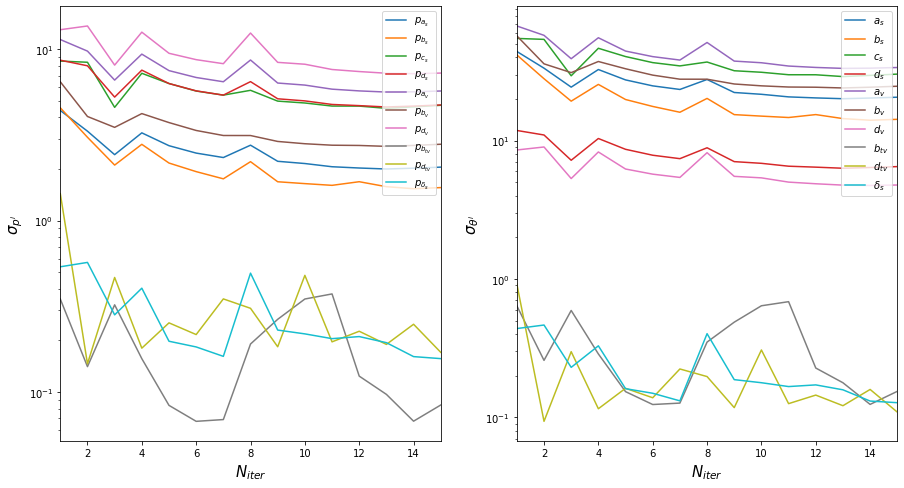

In [50]:
fig,(ax,bx) = plt.subplots(1,2,figsize=(15,8))
for j in range(gs[0][inds].shape[0]):
        ax.plot(np.arange(1,len(gs)+1), [(np.diag(np.linalg.inv(gs[k][inds])))[j]**0.5 for k in range(len(gs))],
                label='${p_{%s}}$'%(['a_s ','b_s ','c_s ','d_s ','a_v ','b_v ','d_v ','b_{tv}','d_{tv}','δ_s ',][j]))
        bx.plot(np.arange(1,len(gs)+1), [(np.abs(DDPC1.θ_bf[np.array([0,1,2,3,4,5,7,9,11,12])])*np.diag(np.linalg.inv(gs[k][inds]))**0.5)[j] for k in range(len(gs))],
                label='${{%s}}$'%(['a_s ','b_s ','c_s ','d_s ','a_v ','b_v ','d_v ','b_{tv}','d_{tv}','δ_s ',][j]))
        ax.legend(loc=1)
        ax.set_xlabel('$N_{iter}$',size=15)
        ax.set_ylabel('$\sigma_{p^i}$',size=15)
        ax.set_yscale('log')
        ax.set_xlim(1,15)
        bx.legend(loc=1)
        bx.set_xlabel('$N_{iter}$',size=15)
        bx.set_ylabel(r'$\sigma_{\theta^i}$',size=15)
        bx.set_yscale('log')
        bx.set_xlim(1,15)